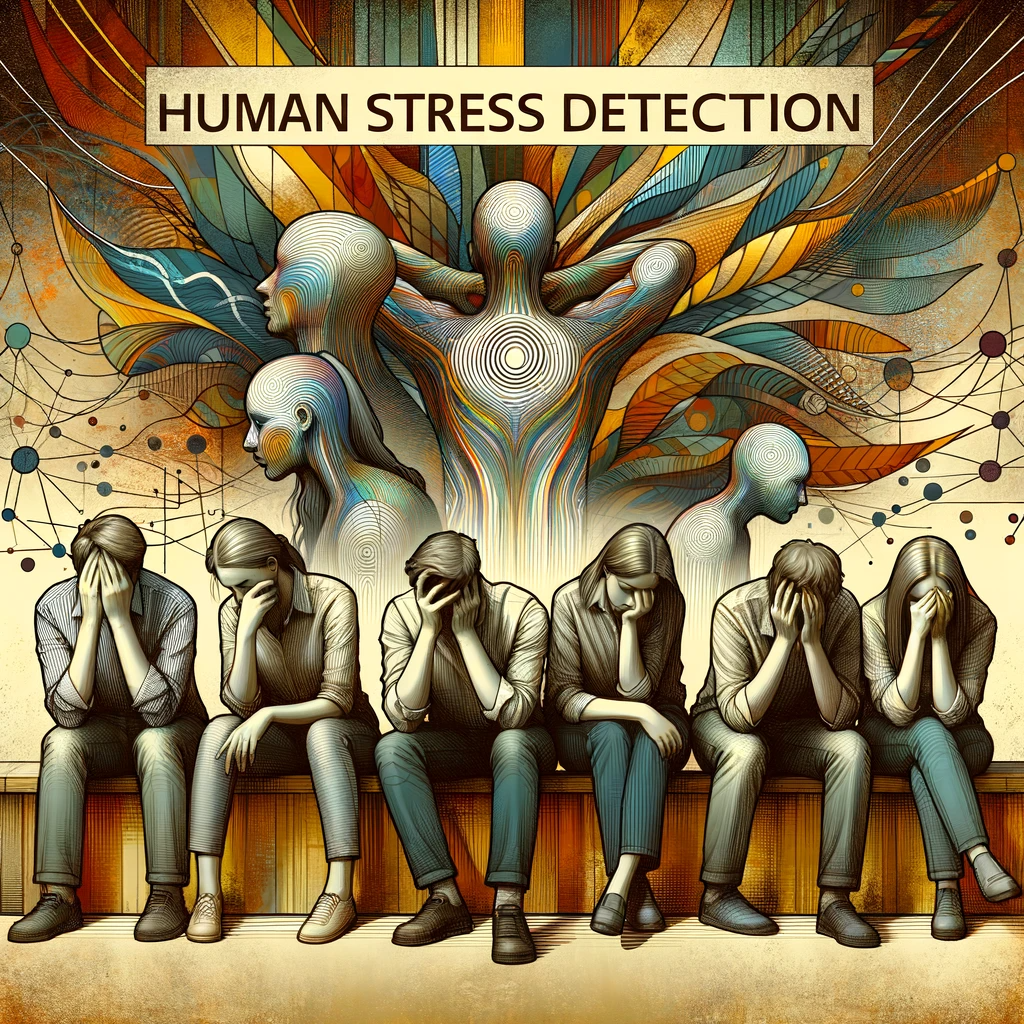

# IMPORTING LIBRARIES

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import nlp
from sklearn.model_selection import LearningCurveDisplay,train_test_split,GridSearchCV
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler,LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer
import re 
import string
import plotly.express as px
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score,confusion_matrix,ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from mlxtend.plotting import plot_decision_regions
from sklearn.metrics import classification_report
from sklearn.naive_bayes import BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline

# Load Dataset

In [2]:

data = pd.read_csv(r"C:\Users\itsla\Downloads\CapstoneProject\Stress.csv")

In [3]:
# def create_label(row):
#     if row['subreddit'] in ['ptsd', 'assistance', 'relationships', 'survivorsofabuse', 'domesticviolence']:
#         if row['confidence'] >= 0.8:
#             return 1  # Stress
#         else:
#             return 0  # No stress
#     elif row['subreddit'] in ['anxiety', 'homeless', 'stress', 'almosthomeless', 'food_pantry']:
#         if row['confidence'] >= 0.6:
#             return 1  # Stress
#         else:
#             return 0  # No stress
#     else:
#         return 0  # Default to No stress
# data['label'] = data.apply(create_label, axis=1)
# print(data)

In [4]:
# def create_stress_label(row, confidence_threshold=0.8, stress_subreddits={'ptsd', 'anxiety', 'domesticviolence'}):
#     # Label as stress if the confidence is above the threshold and the subreddit is one of the stress-related ones
#     if row['confidence'] > confidence_threshold and row['subreddit'] in stress_subreddits:
#         return 1
#     else:
#         return 0
# data['label'] = data.apply(create_stress_label, axis=1)
# data.head()


# Exploratory Data Analysis (EDA)

In [5]:
data.iloc[:5]

subreddit post_id sentence_range  \
0              ptsd  8601tu       (15, 20)   
1        assistance  8lbrx9         (0, 5)   
2              ptsd  9ch1zh       (15, 20)   
3     relationships  7rorpp        [5, 10]   
4  survivorsofabuse  9p2gbc         [0, 5]   

                                                text  label  confidence  \
0  He said he had not felt that way before, sugge...      1         0.8   
1  Hey there r/assistance, Not sure if this is th...      0         1.0   
2  My mom then hit me with the newspaper and it s...      1         0.8   
3  until i met my new boyfriend, he is amazing, h...      1         0.6   
4  October is Domestic Violence Awareness Month a...      1         0.8   

   social_timestamp  
0        1521614353  
1        1527009817  
2        1535935605  
3        1516429555  
4        1539809005

In [6]:
data.shape

(2838, 7)

In [7]:
data['subreddit'].value_counts()

subreddit
ptsd                584
relationships       552
anxiety             503
domesticviolence    316
assistance          289
survivorsofabuse    245
homeless            168
almosthomeless       80
stress               64
food_pantry          37
Name: count, dtype: int64

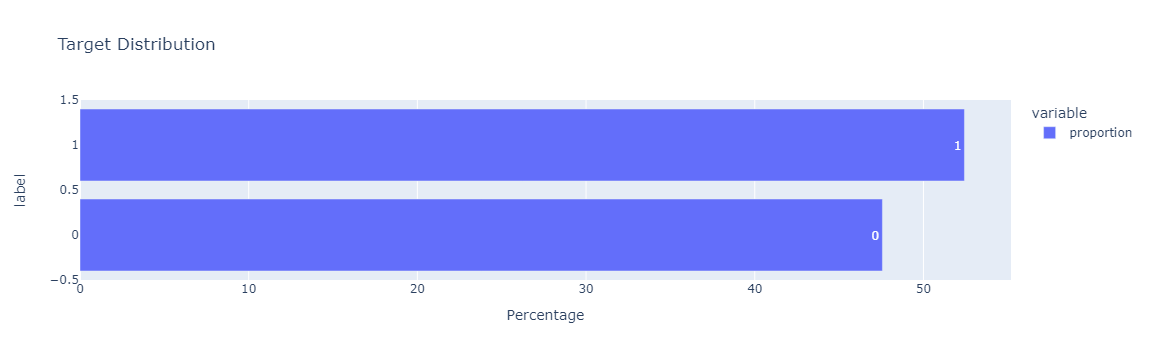

In [8]:
label_counts = data['label'].value_counts(normalize=True) * 100
fig = px.bar(label_counts,
             orientation='h',
             title='Target Distribution',
             labels={'value': 'Percentage', 'index': 'Label'},
             text=label_counts.index)
fig.update_traces(textposition='inside')
fig.show()

In [9]:
data['label_in_value']=data['label'].map({0:'No Stress',1:"Stress"})

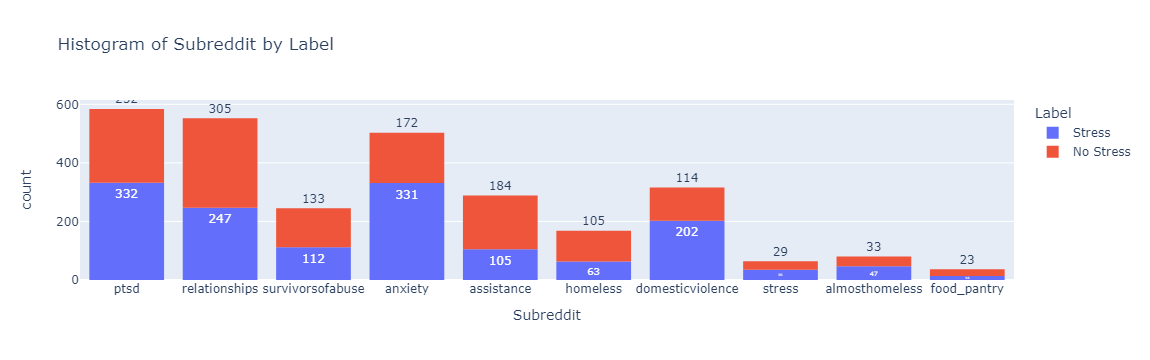

In [10]:
fig = px.histogram(data, x='subreddit', color='label_in_value', nbins=50,
                   title='Histogram of Subreddit by Label',
                   labels={'subreddit': 'Subreddit', 'label_in_value': 'Label'})
counts = data.groupby(['subreddit', 'label_in_value']).size().reset_index(name='count')
fig.update_traces(texttemplate='%{y}', textposition='outside')

fig.show()

### Sunburst chart of subreddit by label

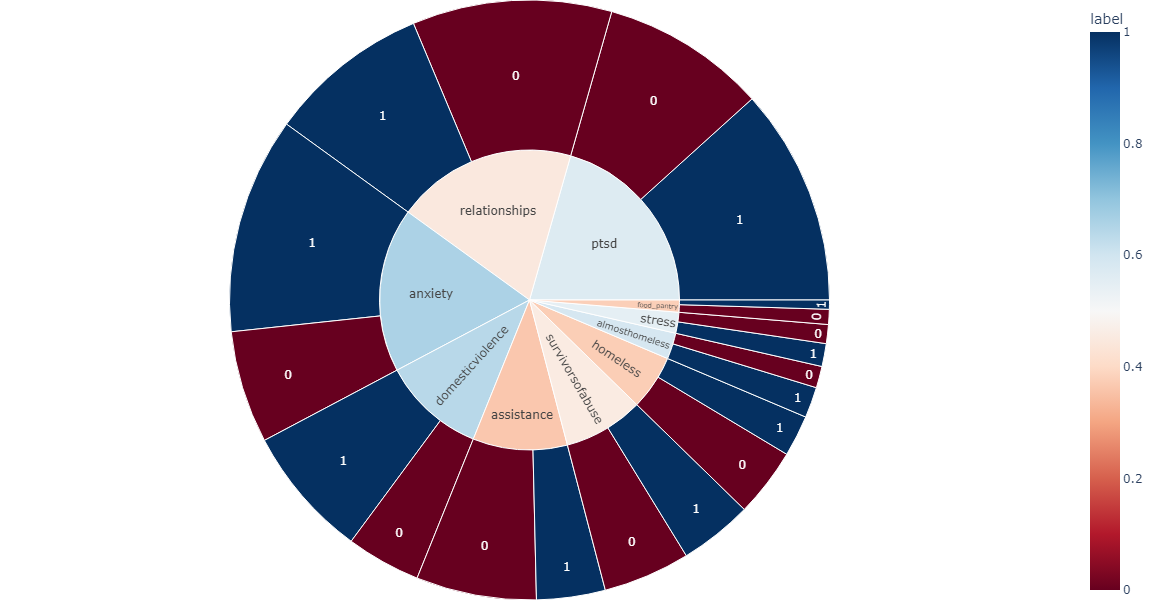

In [11]:
fig = px.sunburst(
    data_frame=data, 
    path=['subreddit', 'label'], 
    color='label',  
    color_continuous_scale='RdBu',
    title='Sunburst Chart of Subreddit and Label Distribution'
)
fig.update_layout(
    width=600, 
    height=600,
    margin=dict(l=0, r=0, t=0, b=0)
)
fig.show()


# Text Preprocessing

In [12]:
def wordopt(text):
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub("\\W"," ",text) 
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)    
    return text

In [13]:
data['text'] = data['text'].apply(wordopt)

In [14]:
data['text']

0       he said he had not felt that way before  sugge...
1       hey there r assistance  not sure if this is th...
2       my mom then hit me with the newspaper and it s...
3       until i met my new boyfriend  he is amazing  h...
4       october is domestic violence awareness month a...
                              ...                        
2833      her  a week ago  precious  how are you   i i...
2834    i don t have the ability to cope with it anymo...
2835    in case this is the first time you re reading ...
2836    do you find this normal  they have a good rela...
2837    i was talking to my mom this morning and she s...
Name: text, Length: 2838, dtype: object

In [15]:
data['text'] = data['text'].apply(word_tokenize)

In [16]:
data['text']

0       [he, said, he, had, not, felt, that, way, befo...
1       [hey, there, r, assistance, not, sure, if, thi...
2       [my, mom, then, hit, me, with, the, newspaper,...
3       [until, i, met, my, new, boyfriend, he, is, am...
4       [october, is, domestic, violence, awareness, m...
                              ...                        
2833    [her, a, week, ago, precious, how, are, you, i...
2834    [i, don, t, have, the, ability, to, cope, with...
2835    [in, case, this, is, the, first, time, you, re...
2836    [do, you, find, this, normal, they, have, a, g...
2837    [i, was, talking, to, my, mom, this, morning, ...
Name: text, Length: 2838, dtype: object

In [17]:
def remove_stopwords(text):
    stpw = set(stopwords.words('english'))
    filtered_text = [word for word in text if word not in stpw]
    return filtered_text

In [18]:
data['text'] = data['text'].apply(remove_stopwords)

In [19]:
data['text']

0       [said, felt, way, suggeted, go, rest, trigger,...
1       [hey, r, assistance, sure, right, place, post,...
2       [mom, hit, newspaper, shocked, would, knows, l...
3       [met, new, boyfriend, amazing, kind, sweet, go...
4       [october, domestic, violence, awareness, month...
                              ...                        
2833    [week, ago, precious, ignored, jan, happy, yea...
2834    [ability, cope, anymore, trying, lot, things, ...
2835    [case, first, time, reading, post, looking, pe...
2836    [find, normal, good, relationship, main, probl...
2837    [talking, mom, morning, said, sister, trauma, ...
Name: text, Length: 2838, dtype: object

In [20]:
def lemmatize_words(text):
    lemmer = WordNetLemmatizer()
    lemmatized_text = [lemmer.lemmatize(word, pos='v') for word in text]
    return lemmatized_text

In [21]:
data['text'] = data['text'].apply(lemmatize_words)

In [22]:
data['text']

0       [say, felt, way, suggeted, go, rest, trigger, ...
1       [hey, r, assistance, sure, right, place, post,...
2       [mom, hit, newspaper, shock, would, know, like...
3       [meet, new, boyfriend, amaze, kind, sweet, goo...
4       [october, domestic, violence, awareness, month...
                              ...                        
2833    [week, ago, precious, ignore, jan, happy, year...
2834    [ability, cope, anymore, try, lot, things, tri...
2835    [case, first, time, read, post, look, people, ...
2836    [find, normal, good, relationship, main, probl...
2837    [talk, mom, morning, say, sister, trauma, wors...
Name: text, Length: 2838, dtype: object

# Feature Engineering - Text Length

In [23]:
data['length'] = data['text'].apply(lambda x: len(x))

In [24]:
data['text'] = data['text'].apply(lambda x: ' '.join([index for index in x]))

# Model Training

In [25]:
X = data['text']
y = data['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Cross-Validation

In [26]:
# Cross-validation for models
models = [RandomForestClassifier(), SVC(), KNeighborsClassifier()]
for model in models:
    pipeline = make_pipeline(TfidfVectorizer(), model)
    scores = cross_val_score(pipeline, X_train, y_train, cv=5)
    print(f"{model.__class__.__name__} Cross-Validation Accuracy: {scores.mean():.4f}")

RandomForestClassifier Cross-Validation Accuracy: 0.7004
SVC Cross-Validation Accuracy: 0.7339
KNeighborsClassifier Cross-Validation Accuracy: 0.6665


# Hyperparameter tuning and grid search cv

In [28]:
# Define the parameter grid for GridSearchCV
pipeline = make_pipeline(TfidfVectorizer(), SVC())
param_grid = {
    'svc__C': [0.1, 1, 10],
    'svc__kernel': ['linear', 'rbf'],
    'svc__gamma': ['scale', 'auto'],
    'tfidfvectorizer__max_features': [None, 1000, 5000],
    'tfidfvectorizer__ngram_range': [(1, 1), (1, 2), (2, 2)]
}
grid_search = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1, verbose=1)

grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)

test_score = grid_search.score(X_test, y_test)
print("Test set accuracy:", test_score)


Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best parameters: {'svc__C': 1, 'svc__gamma': 'scale', 'svc__kernel': 'rbf', 'tfidfvectorizer__max_features': None, 'tfidfvectorizer__ngram_range': (1, 1)}
Best cross-validation score: 0.733920704845815
Test set accuracy: 0.727112676056338


# Principal Component Analysis (PCA)

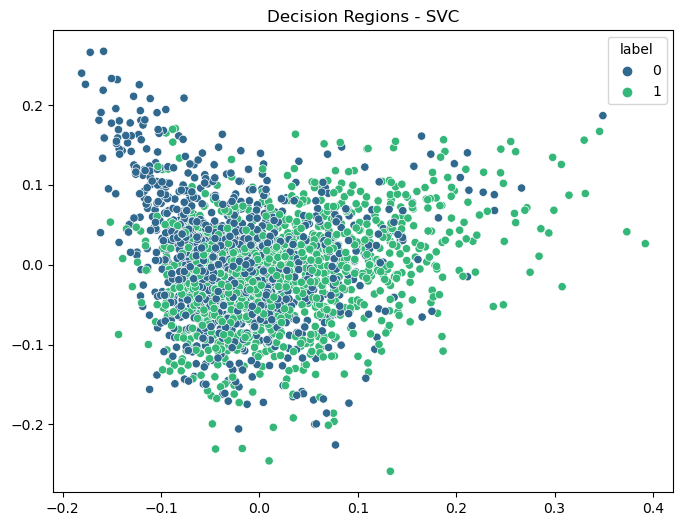

In [57]:
tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)

# Convert the sparse matrix to a NumPy array
X_train_array = np.array(X_train_tfidf.todense())

# Apply PCA to reduce the data to 2 dimensions
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_array)

# Train the SVC model on the original training data
svc_model = SVC()
svc_model.fit(X_train_tfidf, y_train)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_train_pca[:, 0], y=X_train_pca[:, 1], hue=y_train, palette='viridis', legend='full')
plt.title("Decision Regions - SVC")
plt.show()

# Classification Report and Confusion Matrix


Classification Report for SVC:
              precision    recall  f1-score   support

           0       0.72      0.67      0.70       263
           1       0.73      0.77      0.75       305

    accuracy                           0.73       568
   macro avg       0.73      0.72      0.72       568
weighted avg       0.73      0.73      0.73       568



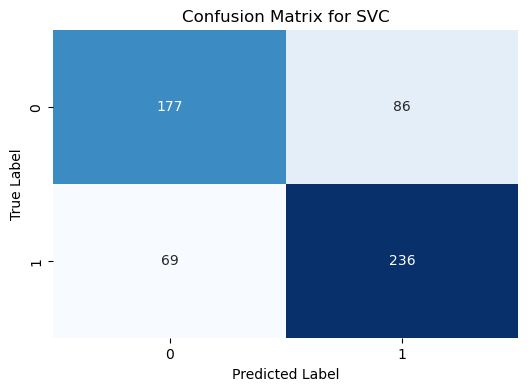

In [30]:
pipeline = make_pipeline(TfidfVectorizer(), SVC())
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
classification_report_svc = classification_report(y_test, y_pred)
print(f"Classification Report for SVC:\n{classification_report_svc}")

def plot_confusion_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.title(f'Confusion Matrix for {model_name}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

plot_confusion_matrix(y_test, y_pred, "SVC")

# Prediction on Trained Data

In [31]:
chosen_model = SVC()
final_pipeline = make_pipeline(TfidfVectorizer(), chosen_model)
final_pipeline.fit(X, y)


Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()), ('svc', SVC())])

# Save the model

In [32]:
# Save the model
import joblib
joblib.dump(final_pipeline, 'stress_detection_model.pkl')

['stress_detection_model.pkl']

# Test on the trained data:

In [33]:
input=pd.DataFrame({
    'text':["I've been feeling really overwhelmed with work lately and can't seem to find any time for myself.",
    "I'm constantly worried about my family's health and our financial situation.",
    "Looking forward to the weekend to relax and read my new book.",
    "The news about the global situation is making me anxious and stressed."]
})

In [34]:
input

text
0  I've been feeling really overwhelmed with work...
1  I'm constantly worried about my family's healt...
2  Looking forward to the weekend to relax and re...
3  The news about the global situation is making ...

In [35]:
# Preprocess the new data
input['text'] = input['text'].apply(word_tokenize)
input['text'] = input['text'].apply(remove_stopwords)
input['text'] = input['text'].apply(lemmatize_words)
input['text'] = input['text'].apply(lambda x: ' '.join([index for index in x]))

In [36]:
vect=TfidfVectorizer(lowercase=False)

In [37]:
X_valid=vect.fit_transform(input['text'])

In [38]:
X_valid = vect.transform(input['text'])

In [56]:
def preprocess_text(text):
    tokens = word_tokenize(text)
    tokens = remove_stopwords(tokens)
    tokens = lemmatize_words(tokens)
    return ' '.join(tokens)

X_train, X_test, y_train, y_test = train_test_split(data['text'], data['label'], test_size=0.2, random_state=42)

pipeline = make_pipeline(TfidfVectorizer(), SVC())
pipeline.fit(X_train, y_train)

X_valid = input['text'].apply(preprocess_text)

input['predicted'] = pipeline.predict(X_valid)
input['predicted'] = input['predicted'].apply(lambda x: 'Stress' if x == 1 else 'Not Stress')


In [40]:
input

text   predicted
0  I 've feel really overwhelm work lately ca n't...      Stress
1  I 'm constantly worry family 's health financi...      Stress
2      Looking forward weekend relax read new book .  Not Stress
3    The news global situation make anxious stress .      Stress

In [55]:
from lazypredict.Supervised import LazyClassifier
from lazypredict.Supervised import LazyRegressor

tfidf = TfidfVectorizer()
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

X_train_dense = X_train_tfidf.todense()
X_test_dense = X_test_tfidf.todense()

X_train_df = pd.DataFrame(X_train_dense, columns=tfidf.get_feature_names_out())
X_test_df = pd.DataFrame(X_test_dense, columns=tfidf.get_feature_names_out())

clf = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=None)
models, predictions = clf.fit(X_train_df, X_test_df, y_train, y_test)

print(models)


 97%|█████████▋| 28/29 [04:03<00:04,  4.88s/it]

[LightGBM] [Info] Number of positive: 1183, number of negative: 1087
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005664 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 19686
[LightGBM] [Info] Number of data points in the train set: 2270, number of used features: 727
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.521145 -> initscore=0.084632
[LightGBM] [Info] Start training from score 0.084632


100%|██████████| 29/29 [04:05<00:00,  8.45s/it]

                               Accuracy  Balanced Accuracy  ROC AUC  F1 Score  \
Model                                                                           
BernoulliNB                        0.76               0.75     0.75      0.75   
NearestCentroid                    0.73               0.73     0.73      0.73   
NuSVC                              0.71               0.71     0.71      0.71   
ExtraTreesClassifier               0.71               0.70     0.70      0.71   
RandomForestClassifier             0.71               0.70     0.70      0.71   
CalibratedClassifierCV             0.71               0.70     0.70      0.71   
PassiveAggressiveClassifier        0.70               0.70     0.70      0.70   
Perceptron                         0.69               0.69     0.69      0.69   
LogisticRegression                 0.69               0.69     0.69      0.69   
SVC                                0.69               0.69     0.69      0.69   
LGBMClassifier              